In [44]:
import sys
sys.path.append('../code/functions')
sys.path.append('../../pipeline_1/code/functions')

import cv2
import glob
import numpy as np
import tiffIO as io
import scipy.io as sio
import neuroGraphLib as ngl
import matplotlib.pyplot as plt

from scipy import ndimage
from cluster import Cluster
from neuroGraphLib import neuroGraph
from scipy.ndimage.filters import convolve
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.morphology import remove_small_objects

In [2]:
procData = []
for mat in glob.glob('collman15v2/*_p1.mat'):
    name = mat[12:-7]
    rawData = sio.loadmat(mat)
    npData = np.rollaxis(rawData[name], 2, 0)
    procData.append([name, npData])


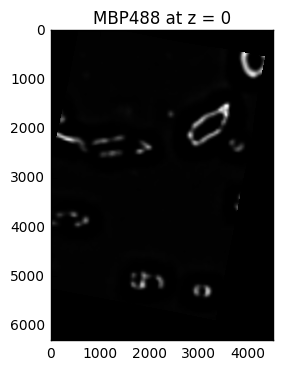

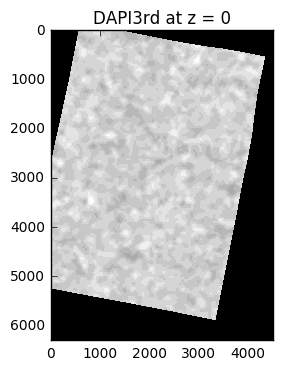

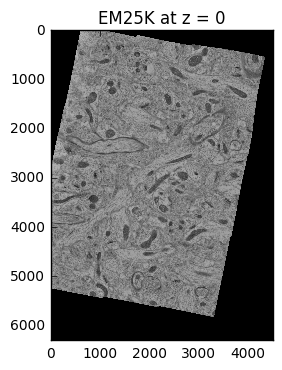

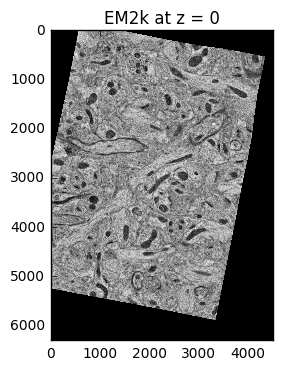

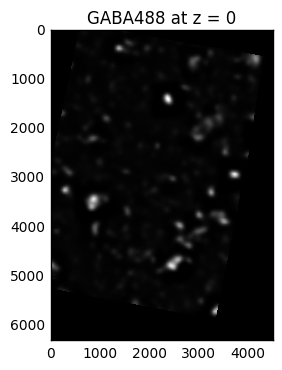

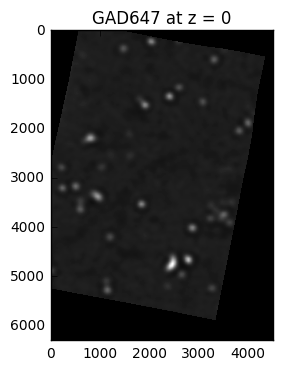

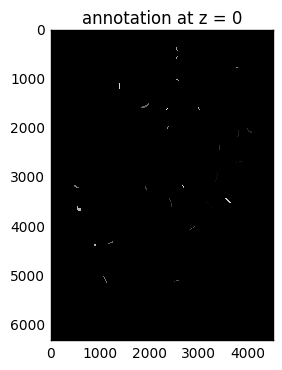

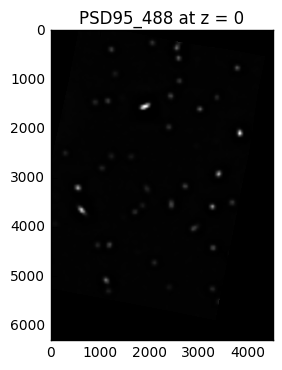

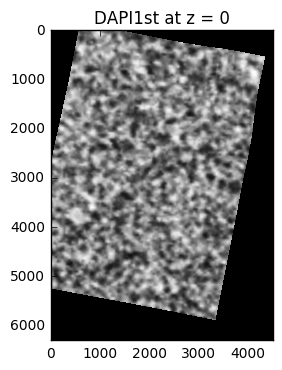

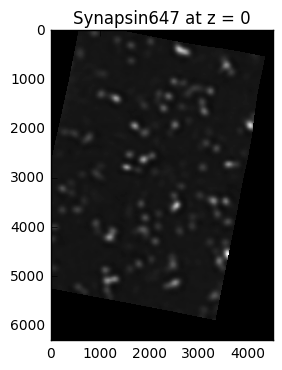

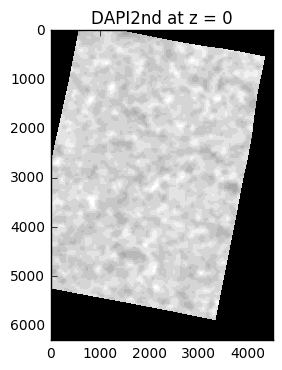

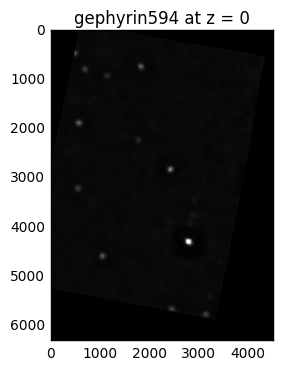

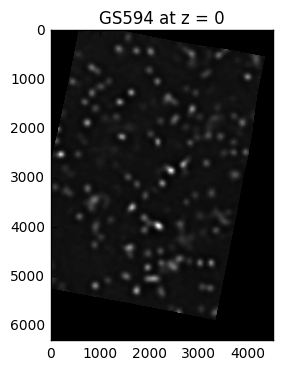

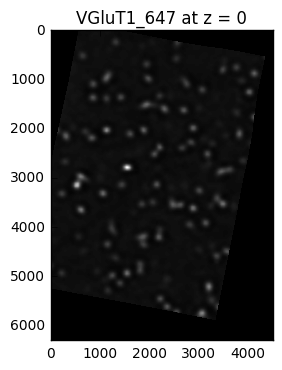

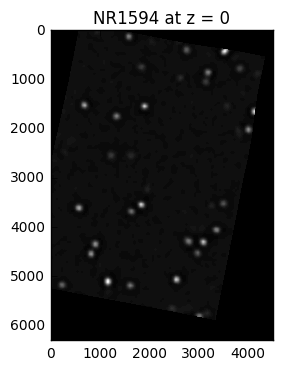

In [3]:
for dataSet in procData:
    plt.figure()
    plt.imshow(dataSet[1][0], cmap='gray')
    plt.title(str(dataSet[0]) + ' at z = 0')
    plt.show()

Since the annotation channel of this data is somewhat suspect, I decided to load some alternate annoation files to compare

In [4]:
import h5py
f = h5py.File('collman15Labels/labels.mat')
f['labelVol']

<HDF5 dataset "labelVol": shape (27, 6306, 4518), type "|u1">

In [5]:
procData[0][1].shape

(9, 6306, 4518)

Interestingly, the labels are exactly 3 times the z span of the p1 data. could this mean they are just stacked p1, p2, p3?

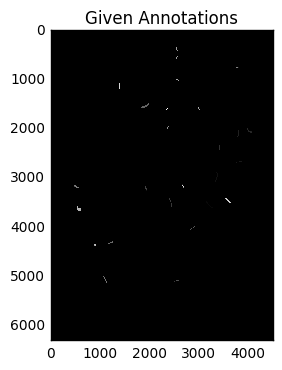

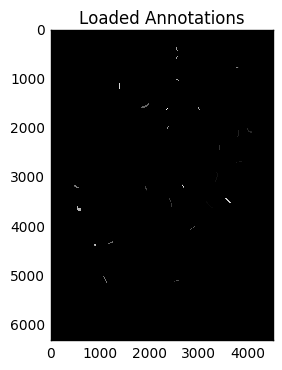

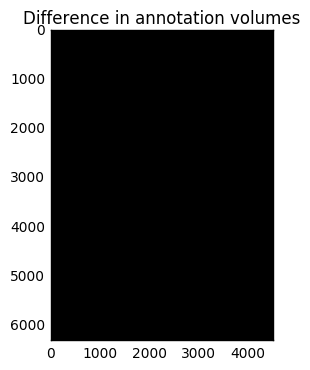


 nonzero after diff:  0


In [6]:
plt.figure()
plt.imshow(procData[6][1][0], cmap='gray')
plt.title('Given Annotations')
plt.show()

plt.figure()
plt.imshow(f['labelVol'][0], cmap='gray')
plt.title("Loaded Annotations")
plt.show()

plt.figure()
diffVol = np.subtract(f['labelVol'][0], procData[6][1][0])
plt.title('Difference in annotation volumes')
plt.imshow(diffVol, cmap='gray')
plt.show()
print '\n nonzero after diff: ',np.count_nonzero(diffVol)

Ok so the annotatons are legit. Next thing I want to be sure about is that we are checking precision, recall, and f1 correctly for this data

In [7]:
def precision_recall_f1(labels, predictions, overlapRatio):
   

    if len(predictions) == 0:
        print 'ERROR: prediction list is empty'
        return 0., 0., 0.
    
    labelFound = np.zeros(len(labels))
    truePositives = 0
    falsePositives = 0

    for prediction in predictions:
        #casting to set is ok here since members are uinque
        predictedMembers = set([tuple(elem) for elem in prediction.getMembers()])
        #detectionCutoff = overlapRatio * len(predictedMembers)
        detectionCutoff = 1
        found = False
        
        for idx, label in enumerate(labels):
            labelMembers = set([tuple(elem) for elem in label.getMembers()])
            #if the predictedOverlap is over the detectionCutoff ratio
            if len(predictedMembers & labelMembers) >= detectionCutoff:
                truePositives +=1
                found=True
                labelFound[idx] = 1
        
        if not found:
            falsePositives +=1
            
    precision = truePositives/float(truePositives + falsePositives)
    recall = np.count_nonzero(labelFound)/float(len(labels))
    f1 = 0
    try:
        f1 = 2 * (precision*recall)/(precision + recall)
        
    except ZeroDivisionError:
        f1 = 0
        
    return precision, recall, f1

I think I may see where the issue was arising. I was checking to see if the overlap between the label and the prediction was greater than the overlap ratio times the volume of the *prediction*. Since, in this data, our predictions are massive compared to the labels, this would not work super well.

I made a change such that the overlap between the label and the prediction be merely nondisjoint.

# Revised Pipeline

In [8]:
import connectLib as cLib

In [9]:
adaptiveOut = cLib.adaptiveThreshold(procData[7][1], 64, 64)

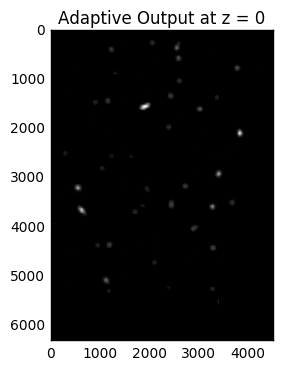

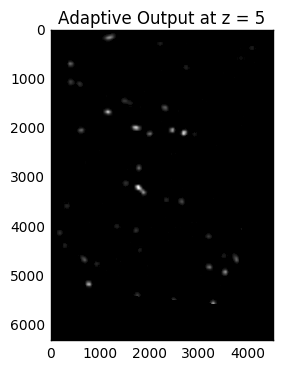

In [10]:
for i in range(0, adaptiveOut.shape[0], 5):
    plt.figure()
    plt.imshow(adaptiveOut[i], cmap='gray')
    plt.title('Adaptive Output at z = '+str(i))
    plt.show()

In [11]:
def fast_cc(volume, n):
    kernel = np.stack([[0, 1, 0],[1, 0, 1], [0, 1, 0]])
    outVol = np.stack([convolve(elem, kernel) for elem in volume])
    return outVol >=n

In [12]:
ccOut = fast_cc((adaptiveOut > 0).astype(int), 3)

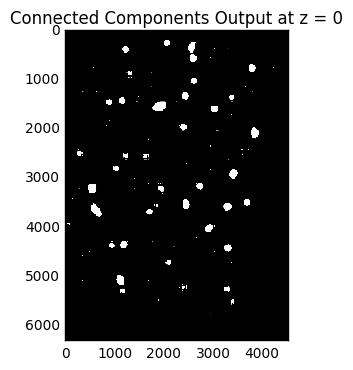

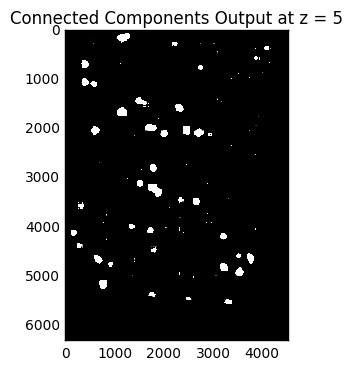

In [13]:
for i in range(0, ccOut.shape[0], 5):
    plt.figure()
    plt.imshow(ccOut[i], cmap='gray')
    plt.title('Connected Components Output at z = '+str(i))
    plt.show()

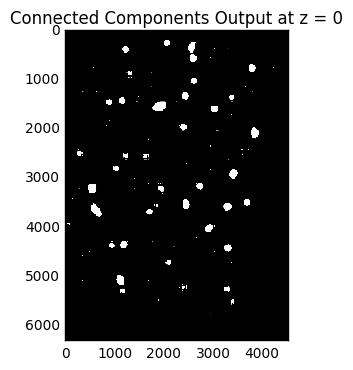

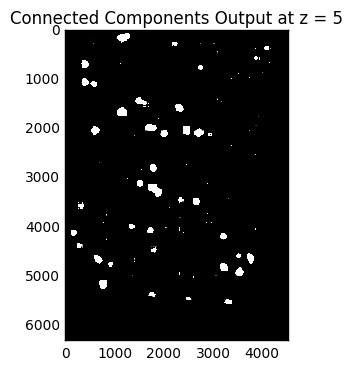

In [14]:
for i in range(0, ccOut.shape[0], 5):
    plt.figure()
    plt.imshow(ccOut[i], cmap='gray')
    plt.title('Connected Components Output at z = '+str(i))
    plt.show()

In [15]:
nonTrivialDist = np.extract(ccOut, procData[7][1])

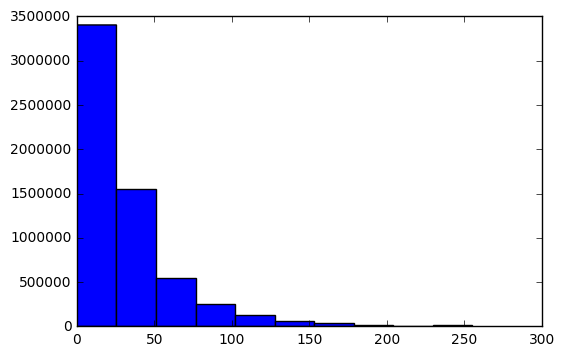

In [16]:
plt.figure()
plt.hist(nonTrivialDist)
plt.show()

In [17]:
mu = np.mean(nonTrivialDist)
sig = np.std(nonTrivialDist)
out  = np.divide(np.subtract(procData[7][1], mu), float(sig))

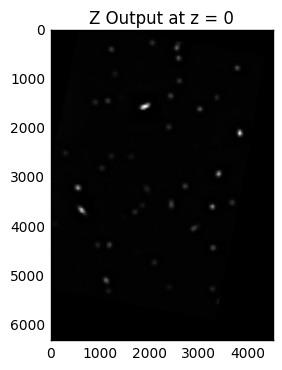

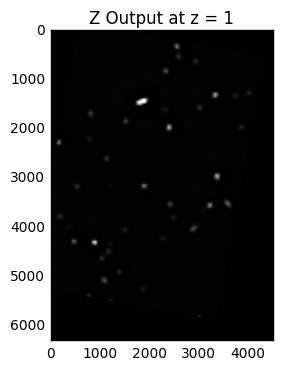

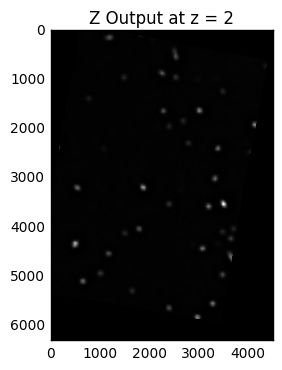

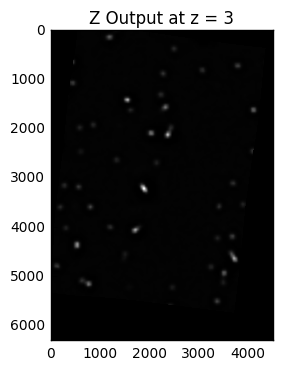

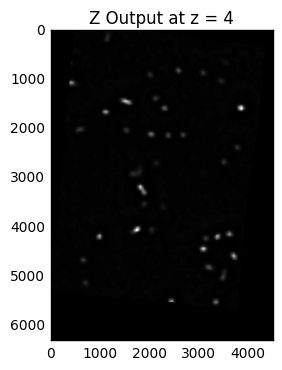

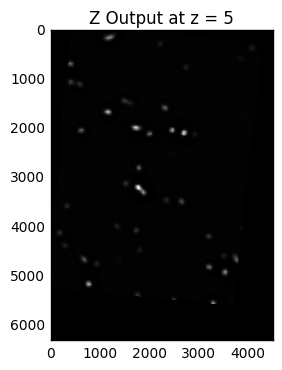

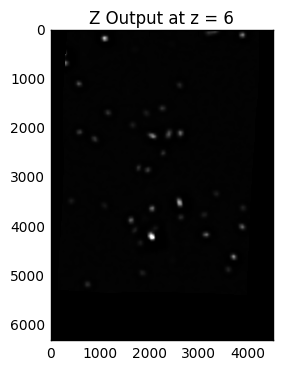

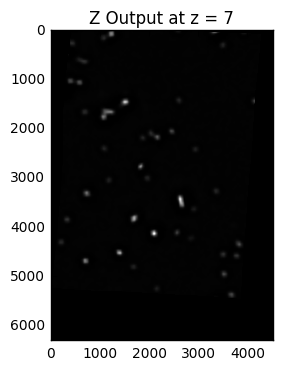

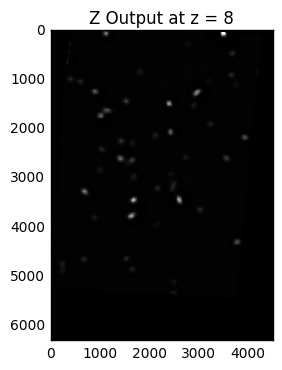

In [18]:
for i in range(0, out.shape[0]):
    plt.figure()
    plt.imshow(out[i], cmap='gray')
    plt.title('Z Output at z = '+str(i))
    plt.show()

It looks like performing the z transform on the ROI doesnt really buy us much... were going to have to take a new approach

In [19]:
testData = procData[7][1] #renaming for convinience

In [20]:
nonTrivial = np.extract(testData > 50, testData)

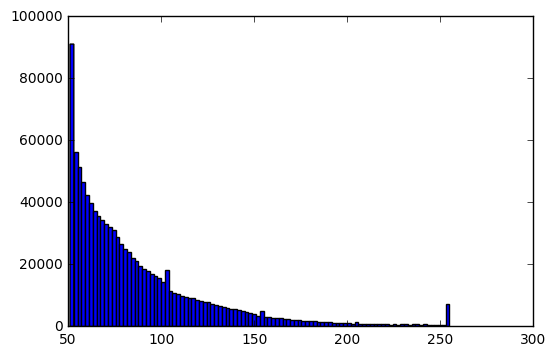

In [21]:
plt.figure()
plt.hist(nonTrivial, bins=100)
plt.show()

The histogram shape here doesnt really buy us much either (the spike at the end can be explained as the data is in the range of 0 to 255

In [22]:
adaptiveOut = cLib.adaptiveThreshold(testData, 64, 64) > 0

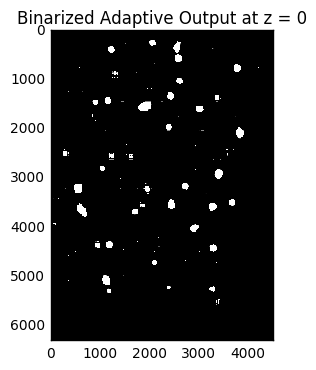

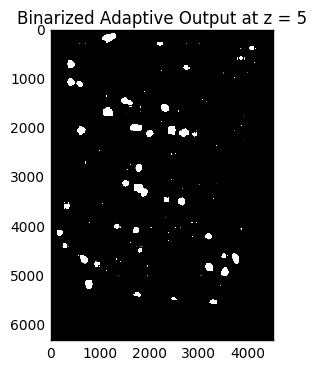

In [23]:
for i in range(0, out.shape[0], 5):
    plt.figure()
    plt.imshow(adaptiveOut[i], cmap='gray')
    plt.title('Binarized Adaptive Output at z = '+str(i))
    plt.show()

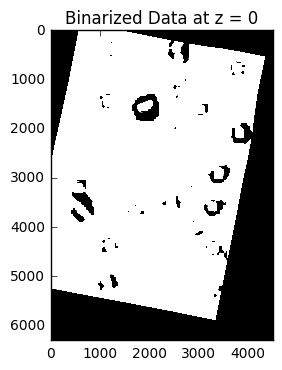

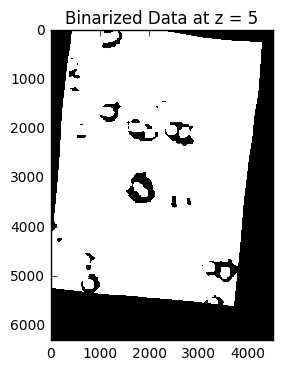

In [24]:
for i in range(0, out.shape[0], 5):
    plt.figure()
    plt.imshow(testData[i] > 0, cmap='gray')
    plt.title('Binarized Data at z = '+str(i))
    plt.show()

It is clear that the adaptive thresholdis doing things. Let's take a page out of jovo's book and just rinse and repeat the alg

In [25]:
adaptiveOut = testData
adaptiveOut = cLib.adaptiveThreshold(adaptiveOut, 64, 64)
adaptiveOut = cLib.adaptiveThreshold(adaptiveOut, 32, 32)
adaptiveOut = cLib.adaptiveThreshold(adaptiveOut, 16, 16)

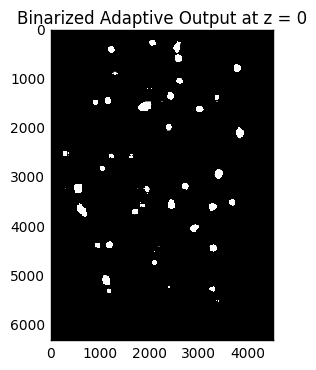

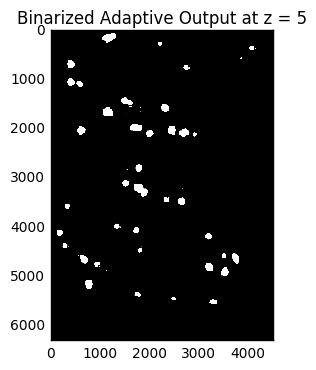

In [26]:
for i in range(0, out.shape[0], 5):
    plt.figure()
    plt.imshow(adaptiveOut[i] > 0, cmap='gray')
    plt.title('Binarized Adaptive Output at z = '+str(i))
    plt.show()

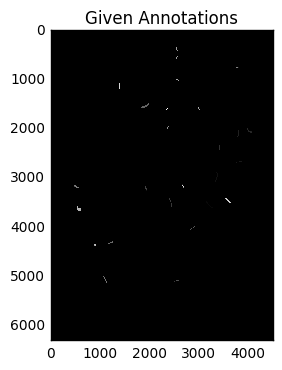

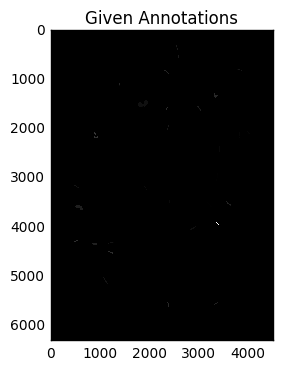

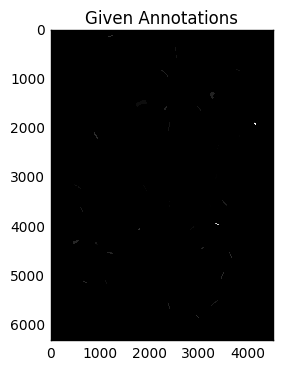

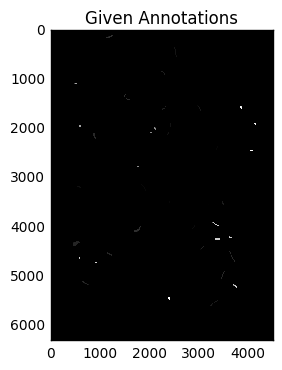

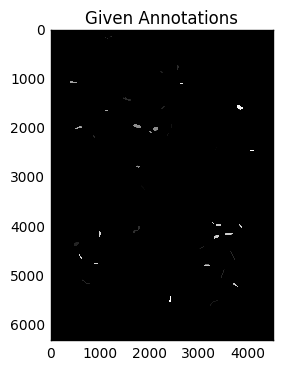

In [27]:
for i in range(5):
    plt.figure()
    plt.imshow(procData[6][1][i], cmap='gray')
    plt.title('Given Annotations')
    plt.show()

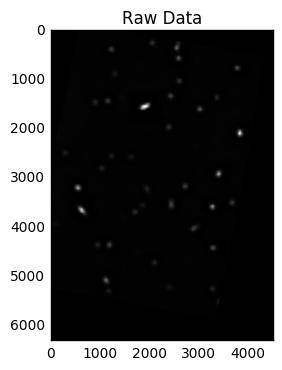

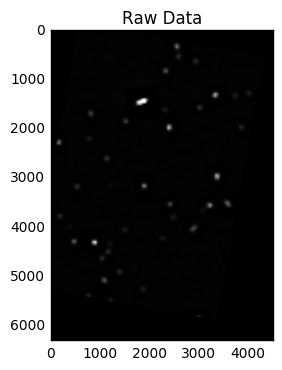

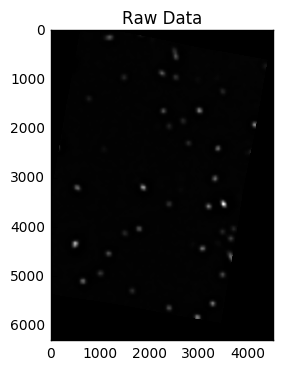

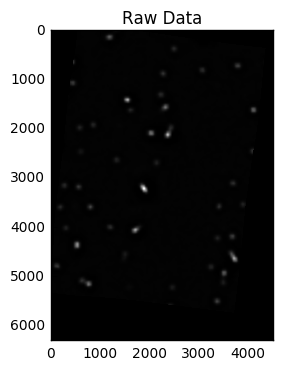

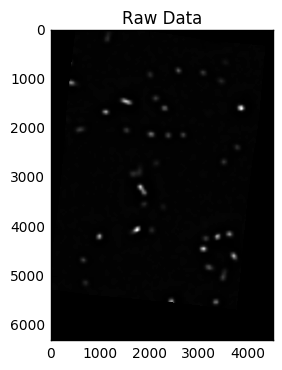

In [28]:
for i in range(5):
    plt.figure()
    plt.imshow(procData[7][1][i], cmap='gray')
    plt.title('Raw Data')
    plt.show()

This pipeline seems to be moving us in circles. Time to try something else.

After sort of staring at the data for a bit, I think that the new strategy is otsu -> ROI Mask -> Erosion -> Clustering -> Non-Maxima Suppression

In [69]:
otsuOut = cLib.otsuVox(testData)

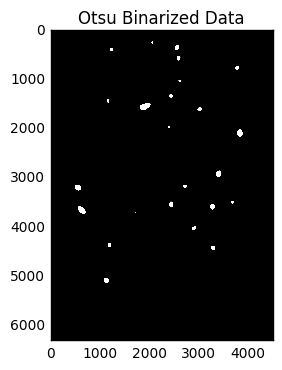

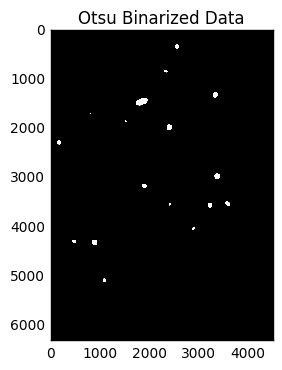

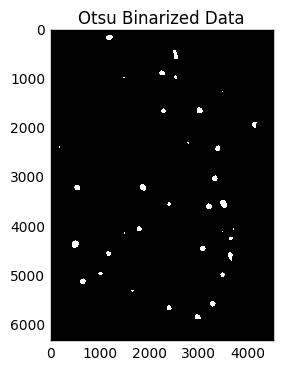

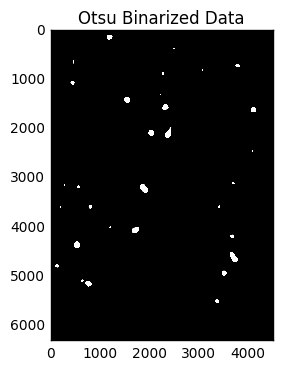

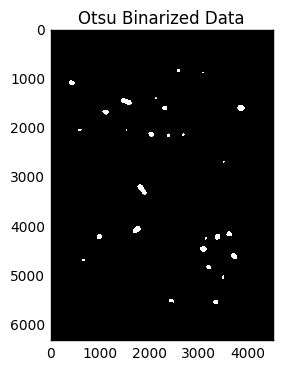

In [70]:
for i in range(5):
    plt.figure()
    plt.imshow(otsuOut[i], cmap='gray')
    plt.title('Otsu Binarized Data')
    plt.show()

This looks more like it. So far so good

In [87]:
clusterList = cLib.clusterThresh(otsuOut, 500, 1000000)

Now let's take a look at the max and average intensity in each of the clusters. I have a feeling that there will be some level of bimodality

In [88]:
aveList = []
maxList = []
for cluster in clusterList:
    curClusterDist = []
    for member in cluster.members:
        curClusterDist.append(testData[member[0]][member[1]][member[2]])
    aveList.append(np.mean(curClusterDist))
    maxList.append(np.max(curClusterDist))
    

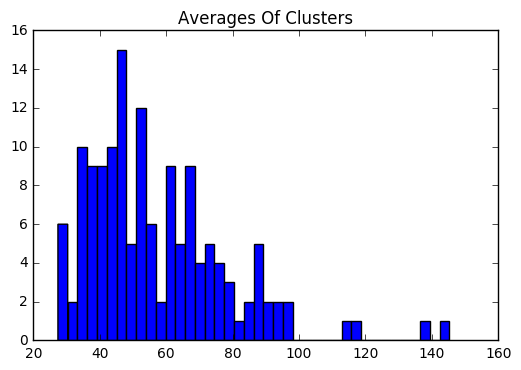

In [110]:
plt.figure()
plt.hist(aveList, bins=40)
plt.title('Averages Of Clusters')
plt.show()

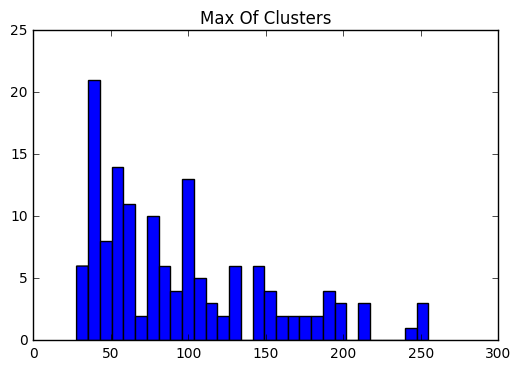

In [90]:
plt.figure()
plt.hist(maxList, bins=30)
plt.title('Max Of Clusters')
plt.show()

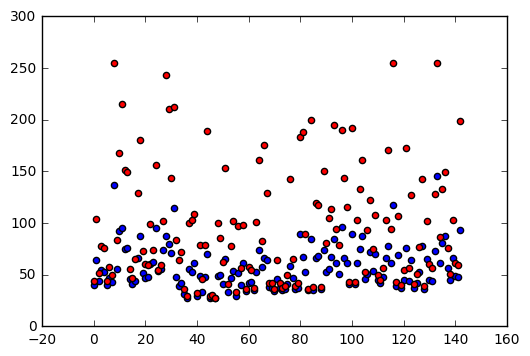

In [91]:
plt.figure()
plt.scatter(range(len(aveList)), aveList, c='b')
plt.scatter(range(len(maxList)), maxList, c='r')
plt.show()

That's what I like to see. The Max clusters exibits clear bimodality. Time to get the otsu threshold for the optimum class breakdown here, and disregard any clusters whose max is under the thresh

In [111]:
#thresh = threshold_otsu(np.array(maxList))
thresh = 47
finalClusters = []
for i in range(len(maxList)): #this is bad and i should feel bad
    if aveList[i] > thresh:
        finalClusters.append(clusterList[i])

In [112]:
outVol = np.zeros_like(testData)
for cluster in finalClusters:
    for member in cluster.members:
        outVol[member[0]][member[1]][member[2]] = 1

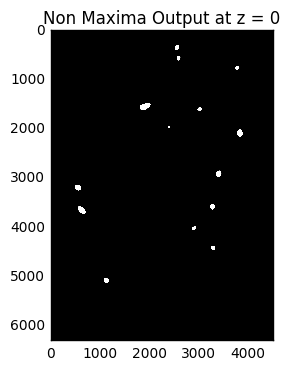

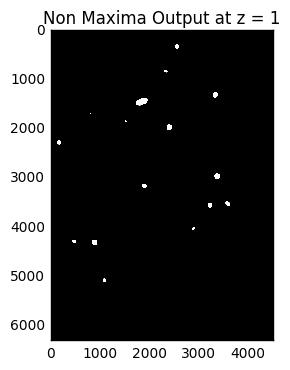

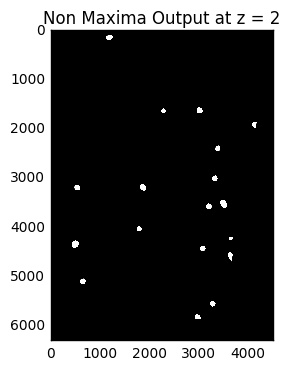

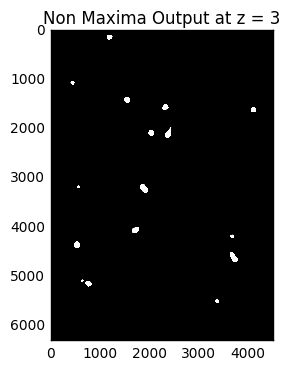

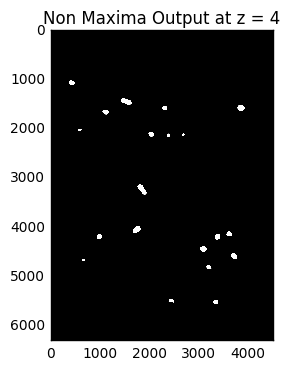

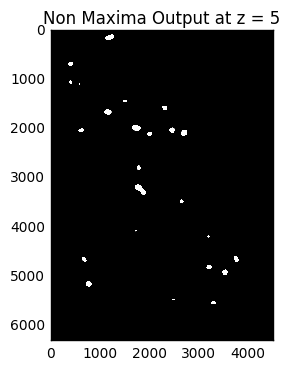

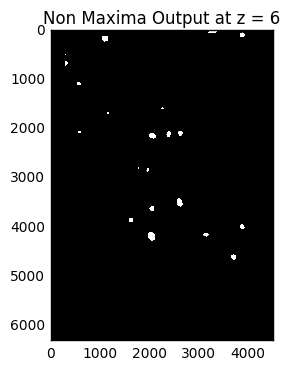

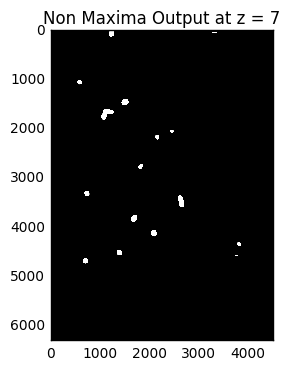

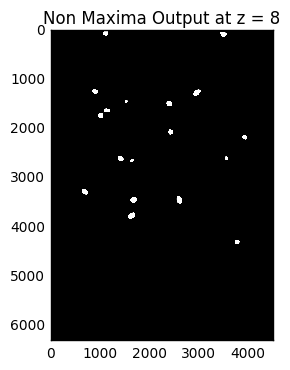

In [113]:
for i in range(0, outVol.shape[0]):
    plt.figure()
    plt.imshow(outVol[i], cmap='gray')
    plt.title('Non Maxima Output at z = '+str(i))
    plt.show()

In [114]:
labelClusters = cLib.clusterThresh(procData[6][1], 0, 10000000)

In [115]:
precision_recall_f1(labelClusters, finalClusters, 1)

(0.9032258064516129, 0.5966386554621849, 0.7185975058738477)